In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data/ethusd_group_project.csv")
data['time'] = pd.to_datetime(data['time'])
#remove NaN values
data = data.dropna()
data.head()

,time,open,close,high,low,volume,"RV_d,t",daily_return,"RV_w,t","RV_m,t",...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
29,2016-06-07,13.949,14.601,14.697,13.880,60569.292389,0.003441,0.046742,0.009780,0.012132,...,98.74,97.561,22.63,26.06,20.48,93.5,298182.29,732442.74,3208.7652,18.5502
30,2016-06-08,14.610,14.410,14.890,14.300,78019.604395,0.003684,-0.013081,0.002820,0.011771,...,98.74,97.561,22.63,26.06,20.48,93.5,298182.29,732442.74,3208.7652,18.5502
31,2016-06-09,14.410,14.494,14.700,14.374,18913.433977,0.001704,0.005829,0.002700,0.011706,...,98.74,97.561,22.63,26.06,20.48,93.5,298182.29,732442.74,3208.7652,18.5502
32,2016-06-10,14.494,13.970,14.510,13.561,63321.457153,0.001990,-0.036153,0.002421,0.011766,...,98.74,97.561,22.63,26.06,20.48,93.5,298182.29,732442.74,3208.7652,18.5502
33,2016-06-11,13.970,14.360,14.383,13.810,37906.991730,0.002509,0.027917,0.002469,0.011603,...,98.74,97.561,22.63,26.06,20.48,93.5,298182.29,732442.74,3208.7652,18.5502


# feature engineering

In [39]:
# Define features & target

features = ['ln_RV_d,t', 'ln_RV_w,t', 'ln_RV_m,t']
target = 'ln_RV_d,t'  # Predicting next day's realized variance

# 2️⃣ Create Input Sequences for LSTM
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])  # Past 60 days as input
        y.append(data[i+lookback, 0])  # Predicting next day's realized variance
    return np.array(X), np.array(y)

# Convert DataFrame to NumPy array for sequence creation
data_values = data[features].values
lookback = 30  # Use 60-day rolling window

# Create sequences
X, y = create_sequences(data_values, lookback)

#visualise first 2 sequences
print(X[0])
print(y[0])


[[-5.6720489  -4.62741087 -4.41191483]
 [-5.60374497 -5.87100631 -4.4421251 ]
 [-6.37463249 -5.91445151 -4.44767437]
 [-6.21960366 -6.02359269 -4.44252823]
 [-5.9877586  -6.00391777 -4.45653147]
 [-5.08086697 -5.76708179 -4.45998973]
 [-4.29713126 -5.35260854 -4.6372732 ]
 [-3.92948847 -4.95445647 -4.62859533]
 [-4.73545675 -4.85623967 -4.62307134]
 [-4.44930822 -4.687928   -4.68083968]
 [-2.13142641 -3.65451637 -4.4785532 ]
 [-2.61313246 -3.32458032 -4.33786921]
 [-3.34666935 -3.21566592 -4.27299027]
 [-3.73329796 -3.17963274 -4.23098511]
 [-4.16436183 -3.19386124 -4.21156182]
 [-3.54903031 -3.12660113 -4.1564182 ]
 [-4.35286335 -3.1227551  -4.14410878]
 [-4.37464609 -3.54453452 -4.12409417]
 [-4.9371878  -3.94068243 -4.1197985 ]
 [-4.9449109  -4.17187892 -4.1129317 ]
 [-5.58083515 -4.3783949  -4.11839459]
 [-4.47860475 -4.42728748 -4.10359061]
 [-4.73348581 -4.69993288 -4.09481758]
 [-5.32674307 -4.83438253 -4.08995474]
 [-5.53764972 -5.00342538 -4.19144735]
 [-5.9850503  -5.10779889

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow import keras

# Train-Test Split
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Convert train data into correct shape
X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten() 
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Further split training into training & validation (80% train, 20% validation)
val_size = int(len(X_train) * 0.2)  # 20% of training data
X_val, y_val = X_train[-val_size:], y_train[-val_size:]  # Last 20% for validation
X_train, y_train = X_train[:-val_size], y_train[:-val_size]  # Remaining for training

print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Define LSTM Model
model = Sequential([
    Input(shape=(lookback, len(features))),
    LSTM(256, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    LSTM(256, return_sequences=True, activation='tanh'), 
    Dropout(0.1),
    LSTM(128, return_sequences=False, activation='tanh'), 
    Dropout(0.1),
    Dense(1, activation=None)
])

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0005), #set learning rate to half of default
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

# Train the LSTM Model
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) #early stopping functionality
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=15, batch_size=16, verbose=1,
                    callbacks=[callback])

# Save the model
model.save('../../results/models/lstm_model.keras')

Training Set: (1671, 30, 3) (1671,)
Validation Set: (417, 30, 3) (417,)
Test Set: (523, 30, 3) (523,)
Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.7229 - mean_absolute_percentage_error: 184.7184 - root_mean_squared_error: 0.8446 - val_loss: 0.3312 - val_mean_absolute_percentage_error: 253.8333 - val_root_mean_squared_error: 0.5711
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.5478 - mean_absolute_percentage_error: 281.5158 - root_mean_squared_error: 0.7364 - val_loss: 0.3047 - val_mean_absolute_percentage_error: 258.4218 - val_root_mean_squared_error: 0.5479
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.5134 - mean_absolute_percentage_error: 204.2966 - root_mean_squared_error: 0.7128 - val_loss: 0.2873 - val_mean_absolute_percentage_error: 275.3506 - val_root_mean_squared_error: 0.5322
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.4826 - mean_absolute_percentage_error: 294.7399 - root_mean_squared_error: 0.6905 - val_

In [54]:
# Load model
model = keras.models.load_model('../../results/models/lstm_model.keras')

# Rolling Forecast for Test Set
predictions = []
history = np.array(X_train[-1])  # Convert last training window to numpy array

for i in range(len(X_test)):
    # Predict the next day's realized variance
    pred = model.predict(history.reshape(1, lookback, len(features)), verbose = 0)[0, 0]
    predictions.append(pred)

    # ✅ Use actual `y_test[i]` instead of `pred` for updating the rolling window
    new_entry = np.hstack([y_test[i], history[-1, 1:]])  # Keep actual value, retain other feature values
    history = np.vstack([history[1:], new_entry])  # Remove oldest, add new actual value

# Convert predictions back from log-scale
predictions = np.exp(scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)))

# Save Predictions
results = pd.DataFrame({
    'time': data['time'].iloc[train_size + lookback:], 
    'RV_forecast': predictions.flatten()
})
results.to_csv("../../results/models/lstm_forecast.csv", index=False)

print("✅ One-day rolling forecast completed and saved!")


✅ One-day rolling forecast completed and saved!


🔹 Mean Squared Error (MSE): 0.000003
🔹 Root Mean Squared Error (RMSE): 0.001606
🔹 Mean Absolute Percentage Error (MAPE): 93.223388%
🔹 R² Score: 0.499160


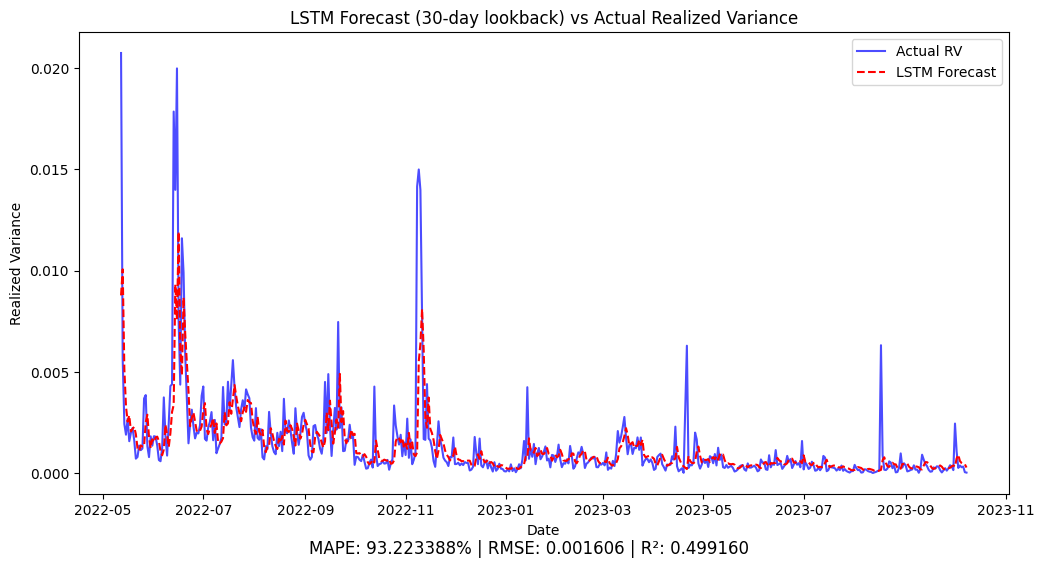

In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Load test set and inverse transform
test_actual = np.exp(scaler_y.inverse_transform(y_test.reshape(-1, 1)))[10:] 

# Load LSTM Forecasts
forecast_df = pd.read_csv("../../results/models/lstm_forecast.csv")
lstm_predictions = forecast_df["RV_forecast"].values[10:]


# 1️⃣ Calculate Error Metrics
mse = mean_squared_error(test_actual, lstm_predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_actual, lstm_predictions)
r2 = r2_score(test_actual, lstm_predictions)

# Print evaluation metrics
print(f"🔹 Mean Squared Error (MSE): {mse:.6f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"🔹 Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"🔹 R² Score: {r2:.6f}")

# 2️⃣ Plot Actual vs Predicted Realized Variance
plt.figure(figsize=(12,6))
plt.plot(data['time'].iloc[-len(test_actual):], test_actual, label="Actual RV", color="blue", alpha=0.7)  # ✅ Ensure time index matches test size
plt.plot(data['time'].iloc[-len(test_actual):], lstm_predictions, label="LSTM Forecast", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Realized Variance")
plt.title(f"LSTM Forecast ({lookback}-day lookback) vs Actual Realized Variance")
plt.legend()

# 3️⃣ Add Captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)

# 4️⃣ Save Before Showing Plot
plt.savefig(f'../../results/figures/lstm_forecast_plot_{lookback}_lookback1.png')
plt.show()
